In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
n_class = 10

X_train = np.reshape(X_train, (-1, 28,  28, 1)) / 255.
X_test = np.reshape(X_test, (-1, 28, 28, 1)) /255.

Y_train = np.eye(n_class)[Y_train]
Y_test = np.eye(n_class)[Y_test]

print("X_train.shape :", X_train.shape)
print("Y_train.shape :", Y_train.shape)
print()
print("X_test.shape :", X_test.shape)
print("Y_test.shape :", Y_test.shape)

X_train.shape : (60000, 28, 28, 1)
Y_train.shape : (60000, 10)

X_test.shape : (10000, 28, 28, 1)
Y_test.shape : (10000, 10)


In [0]:
class Model(object):
  def __init__(self, X_shape, Y_shape, learning_rate):
    self.build_graph(X_shape, Y_shape, learning_rate)
    
  def make_placeholder(self, X_shape, Y_shape):
    self.X = tf.placeholder(tf.float32, [None, X_shape[1], X_shape[2], 1], name="X")
    self.Y = tf.placeholder(tf.int32, [None, Y_shape[1]], name="Y")
    
  def initialize_parameter(self, shape, name):
    var = tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer(seed=20181008))
    return var
  
  def fully_connected_layer(self, X, W, b, activation="softmax"):
    Z = tf.matmul(X, W) + b
    if activation is "softmax":
      A = tf.nn.softmax(Z)
    elif activation is "relu":
      A = tf.nn.relu(Z)
    return A
  
  def conv_layer(self, X, f_size, f_channel, strides, padding, layer):
    W = self.initialize_parameter([f_size, f_size, X.shape[-1], f_channel], "W"+str(layer))
    Z = tf.nn.conv2d(X, W, strides, padding)
    A = tf.nn.relu(Z)
    return A
  
  def pool_layer(self, A, ksize, strides, padding, pool_type="max"):
    if pool_type is "max":
      A = tf.nn.max_pool(A, ksize, strides, padding)
    elif pool_type is "avg":
      A = tf.nn.avg_pool(A, ksize, strides, padding)
    return A
  
  def compute_cost(self, A, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=A, labels=Y))
    return cost
  
  def compute_acc(self, A, Y):
    self.Y_hat = tf.argmax(A, axis=1)
    self.Y_label = tf.argmax(Y, axis=1)
    equals = tf.equal(self.Y_label, self.Y_hat)
    acc = tf.reduce_mean(tf.cast(equals, tf.float32))
    return acc
  
  def build_graph(self, X_shape, Y_shape, learning_rate):
    self.make_placeholder(X_shape, Y_shape)
    with tf.variable_scope("Conv1", reuse=tf.AUTO_REUSE):
      A1 = self.conv_layer(self.X, 5, 10, [1,1,1,1], "SAME", 1)
      A1 = self.pool_layer(A1, [1,2,2,1], [1,2,2,1], "SAME", "max")
      
    with tf.variable_scope("Conv2", reuse=tf.AUTO_REUSE):
      A2 = self.conv_layer(A1, 5, 10, [1,1,1,1], "SAME", 2)
      A2 = self.pool_layer(A2, [1,2,2,1], [1,2,2,1], "SAME", "max")

    A2 = tf.layers.flatten(A2)
    with tf.variable_scope("FC3", reuse=tf.AUTO_REUSE):
      W = self.initialize_parameter([A2.shape[1], Y_shape[1]], "W3")
      b = self.initialize_parameter([Y_shape[1]], "b3")
      
      A3 = self.fully_connected_layer(A2, W, b, "softmax")
     
    with tf.variable_scope("OP", reuse=tf.AUTO_REUSE):

      self.cost = self.compute_cost(A3, self.Y)
      self.acc = self.compute_acc(A3, self.Y)
      self.train = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

In [0]:
epochs = 201
learning_rate = 0.01

myModel = Model(X_train.shape, Y_train.shape, learning_rate)

In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
for epoch in range(epochs):
  _, cost, acc = sess.run([myModel.train, myModel.cost, myModel.acc], feed_dict={myModel.X: X_train, myModel.Y: Y_train})
  if epoch % 10 == 0 :
    print("Epoch:", epoch,"\t", "Cost:",cost,"\t", "Acc:",acc * 100)
print("Train Acc:",acc*100)
acc = sess.run(myModel.acc, feed_dict={myModel.X: X_test, myModel.Y: Y_test})
print("Test Acc:", acc * 100 )

Epoch: 0 	 Cost: 2.3020937 	 Acc: 11.721666902303696
Epoch: 10 	 Cost: 1.7823257 	 Acc: 69.39833164215088
Epoch: 20 	 Cost: 1.5954542 	 Acc: 87.00166940689087
Epoch: 30 	 Cost: 1.5454863 	 Acc: 91.75666570663452
Epoch: 40 	 Cost: 1.5209867 	 Acc: 94.16166543960571
Epoch: 50 	 Cost: 1.5065702 	 Acc: 95.56166529655457
Epoch: 60 	 Cost: 1.4976321 	 Acc: 96.45833373069763
Epoch: 70 	 Cost: 1.4923333 	 Acc: 96.99000120162964
Epoch: 80 	 Cost: 1.4883213 	 Acc: 97.41166830062866
Epoch: 90 	 Cost: 1.4850487 	 Acc: 97.7483332157135
Epoch: 100 	 Cost: 1.4824153 	 Acc: 98.01833629608154
Epoch: 110 	 Cost: 1.480539 	 Acc: 98.20166826248169
Epoch: 120 	 Cost: 1.4793776 	 Acc: 98.29999804496765
Epoch: 130 	 Cost: 1.4779955 	 Acc: 98.44833612442017
Epoch: 140 	 Cost: 1.4770701 	 Acc: 98.55166673660278
Epoch: 150 	 Cost: 1.4763018 	 Acc: 98.60666394233704
Epoch: 160 	 Cost: 1.475543 	 Acc: 98.68999719619751
Epoch: 170 	 Cost: 1.474844 	 Acc: 98.76333475112915
Epoch: 180 	 Cost: 1.4742209 	 Acc: 98.811

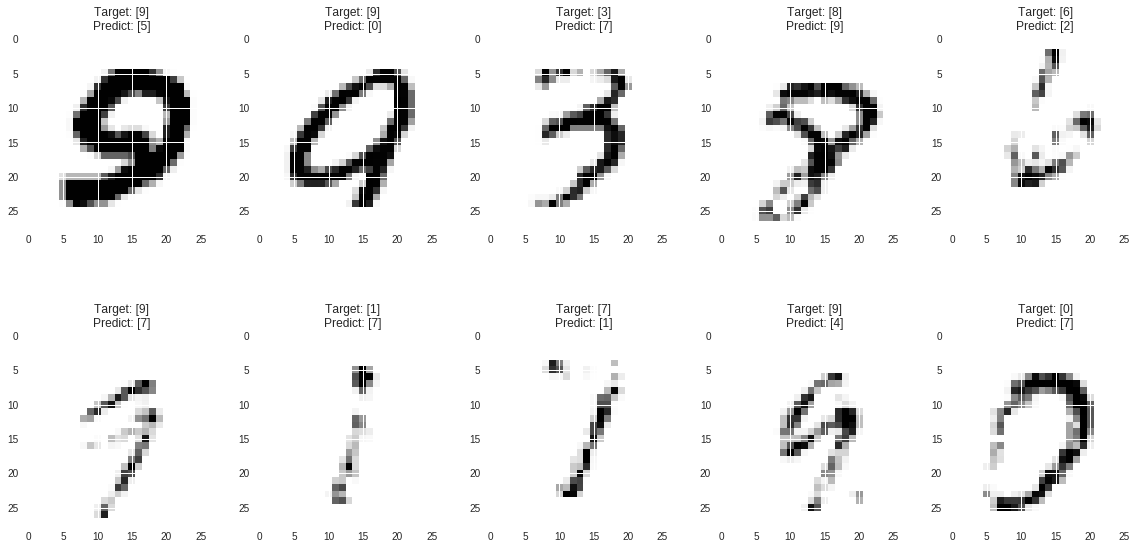

In [6]:
%matplotlib inline
Y_hat, Y_label = sess.run([myModel.Y_hat, myModel.Y_label], feed_dict={myModel.X: X_test, myModel.Y:Y_test})
fig=plt.figure(figsize=(20, 10))

not_equal= Y_hat!=Y_label
imgs = X_test[not_equal] 
r = np.random.randint(len(imgs)-10, size=1)
for i in range(10):
  img = imgs[i+r].reshape(28, 28)
  fig.add_subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title("Target: "+str(Y_label[not_equal][i+r])+"\nPredict: "+ str(Y_hat[not_equal][i+r]) )
